In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q underthesea scikit-learn transformers stopwordsiso

In [3]:
import pandas as pd
import re
import stopwordsiso as stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel

### **Preprocess**

In [4]:
df = pd.read_csv(
    '/content/drive/MyDrive/NLP/toxic_comment_vietnamese/data/processed/labeled.csv',
    encoding='utf-8'
    )

df.head()

,comment,preprocessed_text,predicted_label_id,predicted_label
0,Giống vụ con bé báo tao cháu tô lâm đây . CA b...,giống vụ con bé báo tao cháu tô lâm đây ca bảo...,0,non-toxic
1,BIẾT BỐ MÀY LÀ AI KHÔNG .\nĐMCS .,biết bố mày là ai không đmcs,1,toxic
2,Còn cái này là góp ý. Hy vọng là có đọc cmt. N...,còn cái này là góp ý hy vọng là có đọc cmt nói...,0,non-toxic
3,Bò đỏ lên bình luận cái coi,bò đỏ lên bình luận cái coi,0,non-toxic
4,"Duoc dao tao chinh qui,hoc truong cao cap ,duo...",duoc dao tao chinh quihoc truong cao cap duoc ...,0,non-toxic


In [5]:
# Lấy stopword Tiếng Việt
vi_sw = stopwords.stopwords("vi")
print(vi_sw)

{'dù cho', 'luôn', 'vâng', 'biết đâu chừng', 'vô luận', 'tuy thế', 'khác', 'bằng ấy', 'sau cuối', 'tựu trung', 'ối dào', 'ái dà', 'phỏng như', 'căn', 'úi', 'nhón nhén', 'thực sự', 'cho tới khi', 'phóc', 'cùng cực', 'ớ', 'vô vàn', 'ví bằng', 'tất thảy', 'quá', 'vả lại', 'con', 'nớ', 'toẹt', 'bản', 'cho nên', 'ơ hay', 'dở chừng', 'ngộ nhỡ', 'xuất kỳ bất ý', 'có vẻ', 'bấy nhiêu', 'tà tà', 'vô kể', 'tối ư', 'ôi chao', 'xoẹt', 'bao lâu', 'chốc chốc', 'cần', 'nhất loạt', 'cái', 'hầu hết', 'nó', 'tột', 'dù rằng', 'á', 'đang', 'khi', 'ngoài', 'xệp', 'thành thử', 'ối giời ơi', 'nhiều', 'ngay cả', 'sốt sột', 'rón rén', 'ngày càng', 'thế thì', 'làm', 'ắt', 'nhất thiết', 'nơi', 'nhân tiện', 'như thể', 'nhiên hậu', 'cơ', 'các', 'quả tình', 'vở', 'đại phàm', 'song le', 'amen', 'cật lực', 'ví phỏng', 'pho', 'thế', 'tuần tự', 'xăm xăm', 'thế ra', 'dào', 'bao nả', 'thốt', 'tới', 'tự vì', 'ngay khi', 'tỏ vẻ', 'tò te', 'ấy', 'á à', 'rút cục', 'ngày', 'thái quá', 'ạ', 'chẳng phải', 'dưới', 'nhất tâm', 'tr

In [6]:
# 1. Hàm tiền xử lý cho TF-IDF và BoW (Làm sạch sâu)
def preprocess_for_bow_tfidf(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text, format="text")
    tokens = ' '.join([word for word in tokens.split() if word not in vi_sw])
    return tokens

In [8]:
# Tạo cột mới trong DataFrame
df['text_bow_tfidf'] = df['comment'].apply(preprocess_for_bow_tfidf)

In [9]:
# Loại bỏ khoảng trắng thừa ở đầu và cuối
df['predicted_label'] = df['predicted_label'].str.strip()

# (Tùy chọn) Đồng nhất nhãn nếu có cả '-' và '_'
df['predicted_label'] = df['predicted_label'].str.replace('non_toxic', 'non-toxic')

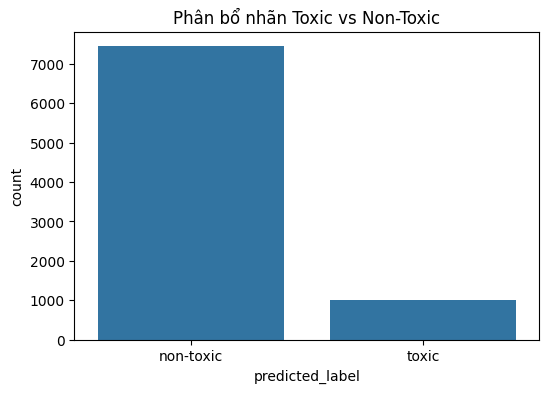

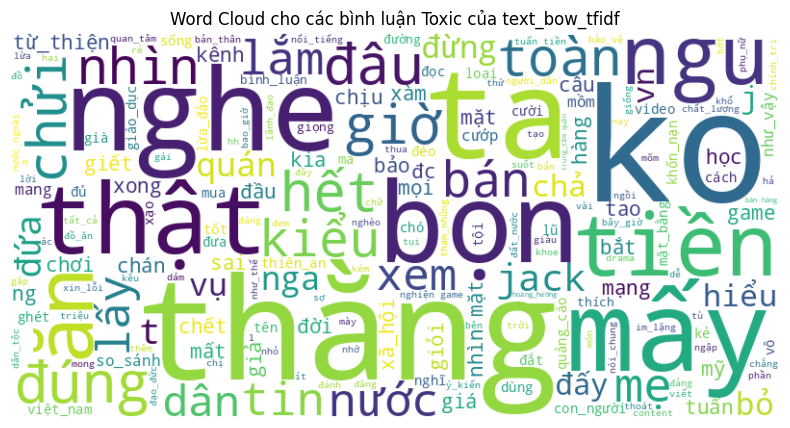

In [24]:
# Phân tích khám phá dữ liệu (EDA)

# 2.1. Phân bổ nhãn
plt.figure(figsize=(6, 4))
sns.countplot(x='predicted_label', data=df)
plt.title('Phân bổ nhãn Toxic vs Non-Toxic')
plt.show()

# 2.3. Trực quan hóa Word Cloud cho nhãn 'toxic' của TF-IDF, BOW
toxic_comments = ' '.join(df[df['predicted_label'] == 'toxic']['text_bow_tfidf'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud cho các bình luận Toxic của text_bow_tfidf')
plt.show()

In [11]:
df.head()

,comment,preprocessed_text,predicted_label_id,predicted_label,text_bow_tfidf,text_phobert
0,Giống vụ con bé báo tao cháu tô lâm đây . CA b...,giống vụ con bé báo tao cháu tô lâm đây ca bảo...,0,non-toxic,giống vụ con_bé báo tao cháu tô_lâm ca bảo_vệ ...,Giống vụ con bé báo tao cháu tô lâm đây . CA b...
1,BIẾT BỐ MÀY LÀ AI KHÔNG .\nĐMCS .,biết bố mày là ai không đmcs,1,toxic,bố_mày đmcs,BIẾT BỐ MÀY LÀ AI KHÔNG .\nĐMCS .
2,Còn cái này là góp ý. Hy vọng là có đọc cmt. N...,còn cái này là góp ý hy vọng là có đọc cmt nói...,0,non-toxic,góp_ý hy_vọng đọc cmt đụng xe nha ko đâm xe đâ...,Còn cái này là góp ý. Hy vọng là có đọc cmt. N...
3,Bò đỏ lên bình luận cái coi,bò đỏ lên bình luận cái coi,0,non-toxic,bò đỏ bình_luận coi,Bò đỏ lên bình luận cái coi
4,"Duoc dao tao chinh qui,hoc truong cao cap ,duo...",duoc dao tao chinh quihoc truong cao cap duoc ...,0,non-toxic,duoc dao tao chinh quihoc truong cap duoc nhie...,"Duoc dao tao chinh qui,hoc truong cao cap ,duo..."


In [12]:
# Lưu DataFrame ra file CSV để dùng cho các bước sau
df.to_csv('/content/drive/MyDrive/NLP/toxic_comment_vietnamese/data/processed/processed_data.csv',
          index=False, encoding='utf-8'
)


### **Encoding and Training with TF-IDF, BOW representation**

In [13]:
df_processed = pd.read_csv(
    '/content/drive/MyDrive/NLP/toxic_comment_vietnamese/data/processed/processed_data.csv',
    encoding='utf-8'
)

df_processed.head()

,comment,preprocessed_text,predicted_label_id,predicted_label,text_bow_tfidf,text_phobert
0,Giống vụ con bé báo tao cháu tô lâm đây . CA b...,giống vụ con bé báo tao cháu tô lâm đây ca bảo...,0,non-toxic,giống vụ con_bé báo tao cháu tô_lâm ca bảo_vệ ...,Giống vụ con bé báo tao cháu tô lâm đây . CA b...
1,BIẾT BỐ MÀY LÀ AI KHÔNG .\nĐMCS .,biết bố mày là ai không đmcs,1,toxic,bố_mày đmcs,BIẾT BỐ MÀY LÀ AI KHÔNG .\nĐMCS .
2,Còn cái này là góp ý. Hy vọng là có đọc cmt. N...,còn cái này là góp ý hy vọng là có đọc cmt nói...,0,non-toxic,góp_ý hy_vọng đọc cmt đụng xe nha ko đâm xe đâ...,Còn cái này là góp ý. Hy vọng là có đọc cmt. N...
3,Bò đỏ lên bình luận cái coi,bò đỏ lên bình luận cái coi,0,non-toxic,bò đỏ bình_luận coi,Bò đỏ lên bình luận cái coi
4,"Duoc dao tao chinh qui,hoc truong cao cap ,duo...",duoc dao tao chinh quihoc truong cao cap duoc ...,0,non-toxic,duoc dao tao chinh quihoc truong cap duoc nhie...,"Duoc dao tao chinh qui,hoc truong cao cap ,duo..."


In [14]:
import pandas as pd
import time, os
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

from datasets import load_dataset
from collections import Counter

In [15]:
df_processed = pd.read_csv(
    '/content/drive/MyDrive/NLP/toxic_comment_vietnamese/data/processed/processed_data.csv',
    encoding='utf-8'
)

# Thay thế bất kỳ giá trị NaN nào bằng một chuỗi rỗng
df_processed['text_bow_tfidf'] = df_processed['text_bow_tfidf'].fillna('')

# Bây giờ mới tạo corpus
corpus = df_processed['text_bow_tfidf'].to_list()

labels = df_processed['predicted_label_id']

In [16]:
vectorizers = {
    'Bag-of-Words': CountVectorizer(max_features=5000),
    'TF-IDF': TfidfVectorizer(max_features=5000)
}

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=None),
    'Support Vector Machine (SVM)': SVC(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest (Bagging)': RandomForestClassifier(random_state=42, n_jobs=-1),
    'AdaBoost (Boosting)': AdaBoostClassifier(random_state=42),
    'XGBoost (Boosting)': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
}

In [17]:
from huggingface_hub import login

login()

In [18]:
benchmark_test_dataset = load_dataset('sonlam1102/vihsd', split='test')
benchmark_test_df = benchmark_test_dataset.to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
print(benchmark_test_df.columns)
# 1. Đổi tên cột cho nhất quán
# Giả sử dữ liệu của bạn có cột 'text_bow_tfidf' và 'predicted_label'
# Dữ liệu vihsd có cột 'text' và 'label'. Ta sẽ đổi tên cột 'text'
benchmark_test_df.rename(columns={
    'free_text': 'comment',
    'label_id': 'label'
}, inplace=True)

# 2. Chuẩn hóa nhãn. Dữ liệu này có 3 nhãn: 0 (NONE), 1 (OFFENSIVE), 2 (HATE)
# Ta sẽ coi 1 và 2 là 'toxic', 0 là 'non-toxic' để giống với bài toán
# Sau đó mã hóa thành số (ví dụ: 1 cho toxic, 0 cho non-toxic)
benchmark_test_df['label_standardized'] = benchmark_test_df['label'].apply(lambda x: 1 if x in [1, 2] else 0)


print("Dữ liệu test benchmark đã được chuẩn hóa:")
benchmark_test_df.head()

Index(['free_text', 'label_id'], dtype='object')
Dữ liệu test benchmark đã được chuẩn hóa:


,comment,label,label_standardized
0,Đừng cố biện minh =)))) choi lon,0,0
1,Haizz. Nthe này thì dân khổ quá,1,1
2,the nay ma chi phat gay roi trat tu cong cong ...,0,0
3,Mua cho em hộp bcs mĩ sài cho oai :)),0,0
4,coin card :3,1,1


In [20]:
X_train_text = corpus
y_train = labels

X_test_text = benchmark_test_df['comment'].astype(str).apply(preprocess_for_bow_tfidf)
y_test = benchmark_test_df['label_standardized']

print("PHÂN BỔ NHÃN BENCHMARK:", Counter(y_test))

# ---------------------- 3) KHAI BÁO VECTORIZER & MODEL ----------------------
vectorizers = {
    'Bag-of-Words': CountVectorizer(max_features=5000),
    'TF-IDF': TfidfVectorizer(max_features=5000)
}

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=None),
    'Support Vector Machine (SVM)': SVC(),  # kernel='linear' thường hợp TF-IDF; để grid quyết định
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest (Bagging)': RandomForestClassifier(random_state=42, n_jobs=-1),
    'AdaBoost (Boosting)': AdaBoostClassifier(random_state=42),
    'XGBoost (Boosting)': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
}

# ---------------------- 4) LƯỚI SIÊU THAM SỐ ----------------------
param_grids_by_model = {
    'Naive Bayes': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__alpha': [0.1, 0.5, 1.0],
    },
    'Logistic Regression': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.5, 1, 10, 100],
        'clf__max_iter': [1000],
        # có thể thêm 'clf__class_weight': ['balanced', None]
    },
    'Support Vector Machine (SVM)': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__C': [0.5, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
    },
    'Decision Tree': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__random_state': [42],
    },
    'Random Forest (Bagging)': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [None, 10, 20],
        'clf__random_state': [42],
        'clf__n_jobs': [-1],
    },
    'AdaBoost (Boosting)': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.1, 0.5, 1.0],
        'clf__random_state': [42],
    },
    'XGBoost (Boosting)': {
        'vec__ngram_range': [(1, 1), (1, 2)],
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.1, 0.05],
        # có thể thêm: 'clf__subsample': [0.8, 1.0], 'clf__colsample_bytree': [0.8, 1.0]
    }
}

PHÂN BỔ NHÃN BENCHMARK: Counter({0: 5548, 1: 1132})


In [21]:
results = []
best_overall = {
    'score': -1.0,
    'grid': None,
    'vec_name': None,
    'model_name': None
}

print("\nBắt đầu GridSearchCV cho từng cặp (Vectorizer, Model)...")
for vec_name, vec in vectorizers.items():
    for model_name, clf in models.items():
        print(f"\n=== Đang thử: VEC = {vec_name} | MODEL = {model_name} ===")

        pipe = ImbPipeline(steps=[
            ('vec', vec),                         # vectorizer CHƯA FIT
            ('ros', RandomOverSampler(random_state=42)), # ROS trong CV (chỉ trên fold-train)
            ('clf', clf)                          # classifier CHƯA FIT
        ])

        param_grid = param_grids_by_model.get(model_name, {})
        if not param_grid:
            print("  * Không có param_grid -> dùng tham số mặc định.")

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid if param_grid else {},
            cv=3,                        # tăng lên 5 khi tài nguyên cho phép
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            refit=True
        )

        grid.fit(X_train_text, y_train)
        best_cv = grid.best_score_ if param_grid else None

        print("  => Best params:", grid.best_params_ if param_grid else "(mặc định)")
        if best_cv is not None:
            print(f"  => Best CV F1_weighted: {best_cv:.4f}")

        # Đánh giá cuối trên benchmark
        y_pred = grid.predict(X_test_text)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Biểu diễn': vec_name,
            'Mô hình': model_name,
            'Cân bằng': 'RandomOverSampler (in-pipeline)',
            'Accuracy (benchmark)': acc,
            'F1-Score (benchmark)': f1,
            'F1-Score (CV_train)': float(best_cv) if best_cv is not None else None
        })

        if f1 > best_overall['score']:
            best_overall.update({
                'score': f1,
                'grid': grid,
                'vec_name': vec_name,
                'model_name': model_name
            })


Bắt đầu GridSearchCV cho từng cặp (Vectorizer, Model)...

=== Đang thử: VEC = Bag-of-Words | MODEL = Naive Bayes ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  => Best params: {'clf__alpha': 0.1, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.7971

=== Đang thử: VEC = Bag-of-Words | MODEL = Logistic Regression ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
  => Best params: {'clf__C': 0.5, 'clf__max_iter': 1000, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8526

=== Đang thử: VEC = Bag-of-Words | MODEL = Support Vector Machine (SVM) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  => Best params: {'clf__C': 0.5, 'clf__kernel': 'rbf', 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8632

=== Đang thử: VEC = Bag-of-Words | MODEL = Decision Tree ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  => Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__random_state': 42, 'vec

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  => Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 400, 'vec__ngram_range': (1, 2)}
  => Best CV F1_weighted: 0.8548

=== Đang thử: VEC = TF-IDF | MODEL = Naive Bayes ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  => Best params: {'clf__alpha': 0.1, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8059

=== Đang thử: VEC = TF-IDF | MODEL = Logistic Regression ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
  => Best params: {'clf__C': 1, 'clf__max_iter': 1000, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8522

=== Đang thử: VEC = TF-IDF | MODEL = Support Vector Machine (SVM) ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  => Best params: {'clf__C': 0.5, 'clf__kernel': 'rbf', 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8688

=== Đang thử: VEC = TF-IDF | MODEL = Decision Tree ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  => Best params: {'clf__max

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  => Best params: {'clf__max_depth': None, 'clf__n_estimators': 400, 'clf__n_jobs': -1, 'clf__random_state': 42, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8703

=== Đang thử: VEC = TF-IDF | MODEL = AdaBoost (Boosting) ===
Fitting 3 folds for each of 18 candidates, totalling 54 fits
  => Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 100, 'clf__random_state': 42, 'vec__ngram_range': (1, 1)}
  => Best CV F1_weighted: 0.8527

=== Đang thử: VEC = TF-IDF | MODEL = XGBoost (Boosting) ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:57:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  => Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 400, 'vec__ngram_range': (1, 2)}
  => Best CV F1_weighted: 0.8596


In [23]:
REPORT_DIR = '/content/drive/MyDrive/NLP/toxic_comment_vietnamese/reports'
results_df = pd.DataFrame(results).sort_values(by='F1-Score (benchmark)', ascending=False)
print("\n\n--- BẢNG KẾT QUẢ (đánh giá trên benchmark) ---")
print(results_df.round(4))

csv_path = os.path.join(REPORT_DIR, 'benchmark_results_cv.csv')
results_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"\n✅ Đã lưu bảng kết quả: {csv_path}")

# ---------------------- 7) MÔ HÌNH TỐT NHẤT & LƯU PIPELINE ----------------------
print("\n--- MÔ HÌNH TỐT NHẤT ---")
print(f"Vectorizer: {best_overall['vec_name']}")
print(f"Model: {best_overall['model_name']}")
if hasattr(best_overall['grid'], "best_params_") and best_overall['grid'].best_params_:
    print("Best params:", best_overall['grid'].best_params_)
print(f"F1-Score (benchmark): {best_overall['score']:.4f}")

final_model_pipeline = best_overall['grid'].best_estimator_

timestamp = time.strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(REPORT_DIR, f"final_pipeline_{best_overall['model_name']}_{best_overall['vec_name']}_{timestamp}.joblib")
joblib.dump(final_model_pipeline, model_path)
print(f"💾 Đã lưu pipeline cuối cùng: {model_path}")



--- BẢNG KẾT QUẢ (đánh giá trên benchmark) ---
       Biểu diễn                       Mô hình  \
3   Bag-of-Words                 Decision Tree   
10        TF-IDF                 Decision Tree   
6   Bag-of-Words            XGBoost (Boosting)   
5   Bag-of-Words           AdaBoost (Boosting)   
12        TF-IDF           AdaBoost (Boosting)   
11        TF-IDF       Random Forest (Bagging)   
9         TF-IDF  Support Vector Machine (SVM)   
13        TF-IDF            XGBoost (Boosting)   
1   Bag-of-Words           Logistic Regression   
4   Bag-of-Words       Random Forest (Bagging)   
2   Bag-of-Words  Support Vector Machine (SVM)   
8         TF-IDF           Logistic Regression   
7         TF-IDF                   Naive Bayes   
0   Bag-of-Words                   Naive Bayes   

                           Cân bằng  Accuracy (benchmark)  \
3   RandomOverSampler (in-pipeline)                0.8283   
10  RandomOverSampler (in-pipeline)                0.8284   
6   RandomOverSam

In [27]:
df = pd.read_csv("/content/drive/MyDrive/NLP/toxic_comment_vietnamese/reports/benchmark_results_cv.csv")
metric_cols = ["Accuracy (benchmark)", "F1-Score (benchmark)"]

styled = (
    df.style
      .highlight_max(subset=metric_cols, color="#b7f7c5")
      .background_gradient(subset=metric_cols, cmap="YlGn")
      .format({c: "{:.4f}" for c in metric_cols})
)

# Thanh màu trong ô
styled_bars = (
    df.style
      .bar(subset=metric_cols, color="#cfe8ff")
      .format({c: "{:.4f}" for c in metric_cols})
)

# Tô nổi Top-3 theo F1
def highlight_topn(s, n=3):
    top_idx = s.nlargest(n).index
    return ["background-color: #fff3bf" if i in top_idx else "" for i in s.index]

styled_top3 = df.style.apply(
    lambda _: highlight_topn(df["F1-Score (benchmark)"], n=3), axis=0
).format({"F1-Score (benchmark)": "{:.4f}"})


In [29]:
styled.to_html("benchmark_report.html")
styled.to_excel("benchmark_report.xlsx", engine="openpyxl")